<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/3-Numerical_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

Load necessary libraries.

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

Load data:

In [17]:

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([df.values[::2, :], df.values[1::2, :2]])
target = df.values[1::2, 2]

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

 More information about the dataset and also related ethical problems can be found in the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

Attribute Information:

1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per \$10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in \$1000's

In [18]:
df.columns = ['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0,0.538,6.142,91.7,3.9769,4,307.0,21.0,396.90,18.72,15.2
1,0.98843,0.0,8.14,0,0.538,5.813,100.0,4.0952,4,307.0,21.0,394.54,19.88,14.5
2,0.75026,0.0,8.14,0,0.538,5.924,94.1,4.3996,4,307.0,21.0,394.33,16.30,15.6
3,0.84054,0.0,8.14,0,0.538,5.599,85.7,4.4546,4,307.0,21.0,303.42,16.51,13.9
4,0.67191,0.0,8.14,0,0.538,5.813,90.3,4.6820,4,307.0,21.0,376.88,14.81,16.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
480,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
481,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
482,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


No missing datapoints:

In [19]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Select the 'LSTAT' and 'RM' features as predictors:

In [20]:
X = pd.DataFrame(np.c_[df['LSTAT'], df['RM']], columns = ['LSTAT','RM'])
Y = df['MEDV']
X

,LSTAT,RM
0,18.72,6.142
1,19.88,5.813
2,16.30,5.924
3,16.51,5.599
4,14.81,5.813
...,...,...
479,9.67,6.593
480,9.08,6.120
481,5.64,6.976
482,6.48,6.794


In [21]:
X.min(axis=0)

LSTAT    1.730
RM       3.561
dtype: float64

In [22]:
X.max(axis=0)

LSTAT    37.97
RM        8.78
dtype: float64

Split training and test data:

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(387, 2)
(97, 2)
(387,)
(97,)


Fit the model:

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

Evaluate the model using MSE and R-Squared.

- MSE represents the residual error which is nothing but sum of squared difference between actual values and the predicted / estimated values divided by total number of records.

- R-Squared represents the fraction of variance captured by the regression model.

- The disadvantage of using MSE is that the value of MSE varies based on whether the values of response variable is scaled or not. If scaled, MSE will be lower than the unscaled values.

In [25]:
# model evaluation for training set
y_train_predict = lr_model.predict(X_train)
mse = mean_squared_error(Y_train, y_train_predict)
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lr_model.predict(X_test)
mse = mean_squared_error(Y_test, y_test_predict)
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
MSE is 28.686850515093248
R2 score is 0.6586161721692037


The model performance for testing set
--------------------------------------
MSE is 41.53485668760201
R2 score is 0.5610200837571802


In [26]:
def visualize(X, Y, model):
  x= X['LSTAT']
  y= X['RM']
  z = Y

  N = 100
  x_pred = np.linspace(1, 40, N)   # N values in the range of LSTAT 
  y_pred = np.linspace(3.5, 8.8, N)  # N values in the range of RM
  xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
  model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
  model_vizz = pd.DataFrame(model_viz, columns = ['LSTAT','RM'])

  predicted = model.predict(model_vizz)
  zz_pred = predicted.reshape(N,N)

  plt.style.use('default')

  fig = plt.figure(figsize=(12, 4))

  ax1 = fig.add_subplot(131, projection='3d')
  ax2 = fig.add_subplot(132, projection='3d')
  ax3 = fig.add_subplot(133, projection='3d')

  axes = [ax1, ax2, ax3]

  for ax in axes:
      surf = ax.plot_surface(xx_pred, yy_pred, zz_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)
      ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='.', alpha=0.35)

      ax.set_xlabel('LSTAT')
      ax.set_ylabel('RM')
      ax.set_zlabel('MEDV')
      
  ax1.view_init(elev=28, azim=120)
  ax2.view_init(elev=4, azim=114)
  ax3.view_init(elev=60, azim=165)
  fig.tight_layout(pad=2.5)
  fig.colorbar(surf, shrink=0.75, pad=0.15)


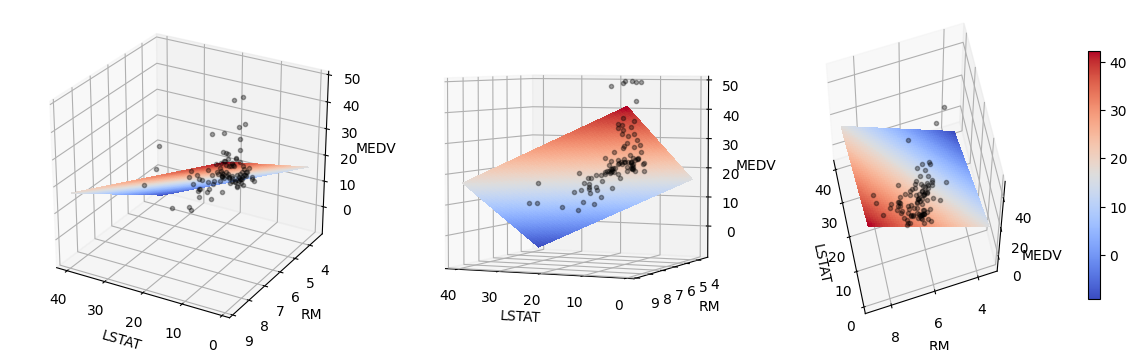

In [27]:
visualize(X_test, Y_test, lr_model)

# KNN Regression

KNN regression is an alternative approach to numerical regression.

In [28]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, Y_train)

KNeighborsRegressor()

In [29]:
# model evaluation for training set
y_train_predict = knn_model.predict(X_train)
mse = mean_squared_error(Y_train, y_train_predict)
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = knn_model.predict(X_test)
mse = mean_squared_error(Y_test, y_test_predict)
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
MSE is 12.63762377260982
R2 score is 0.8496077366210313


The model performance for testing set
--------------------------------------
MSE is 29.394812371134027
R2 score is 0.6893276322172666


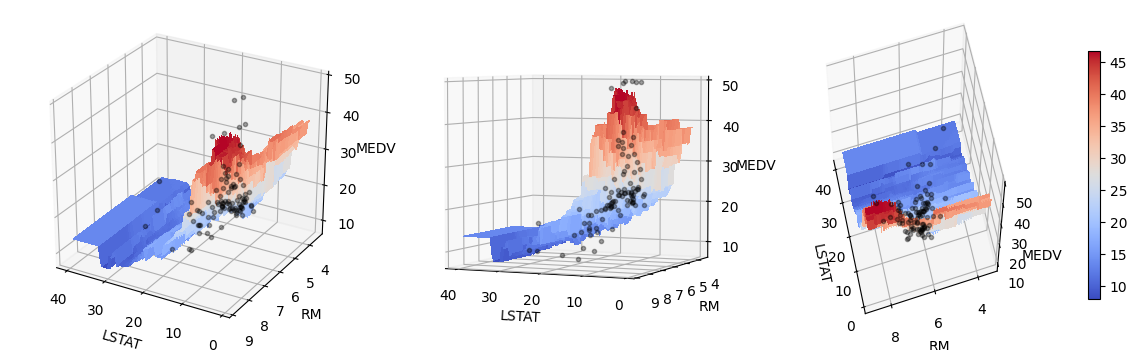

In [30]:
visualize(X_test, Y_test, knn_model)

# Advanced: Feature selection

Again all features and their values:

In [31]:
XX = df.drop('MEDV',axis=1)
XX

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0,0.538,6.142,91.7,3.9769,4,307.0,21.0,396.90,18.72
1,0.98843,0.0,8.14,0,0.538,5.813,100.0,4.0952,4,307.0,21.0,394.54,19.88
2,0.75026,0.0,8.14,0,0.538,5.924,94.1,4.3996,4,307.0,21.0,394.33,16.30
3,0.84054,0.0,8.14,0,0.538,5.599,85.7,4.4546,4,307.0,21.0,303.42,16.51
4,0.67191,0.0,8.14,0,0.538,5.813,90.3,4.6820,4,307.0,21.0,376.88,14.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
480,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
481,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
482,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


All features give a certain $R^2$ value (in training data in linear regressin). 

In [32]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, Y, test_size = 0.2, random_state=5)

In [33]:
def train_and_test(XX_train, XX_test, YY_train, YY_test):
  lr_model = LinearRegression()
  lr_model.fit(XX_train, YY_train)
  y_test_predict = lr_model.predict(XX_test)
  return r2_score(YY_test, y_test_predict)

In [34]:
train_and_test(XX_train, XX_test, YY_train, YY_test)

0.6663125152901721

Less could be more, i.e., fewer features could lead to a better model. Feature selection tries to select the most relevant ones. This could be done in many ways. Two step-by-step, recursive approaches **eliminate** features from the full feature set and **agglomerate** features to the empty set, respectively. 

Recursive elimination of features one by one until the $R^2$ statistics doesn't increase.

In [35]:
def eliminate(XX_train, XX_test, verbose):
  drop_col = ''
  r2_max = train_and_test(XX_train, XX_test, YY_train, YY_test)
  for (colname, _) in XX_train.iteritems():
    XX_train_ = XX_train.drop(colname,axis=1)
    XX_test_ = XX_test.drop(colname,axis=1)
    r2 = train_and_test(XX_train_, XX_test_, YY_train, YY_test)
    if r2 >= r2_max:
      if verbose:
        print("maybe remove ",colname)
        print("R2 =", r2)
      drop_col = colname
      r2_max = r2
  if drop_col != '':
    if verbose:
      print("remove ",colname)
    XX_train_ = XX_train.drop(drop_col,axis=1)
    XX_test_ = XX_test.drop(drop_col,axis=1)
    res = eliminate(XX_train_, XX_test_, verbose)
  else:
    res = list(XX_train.columns)
  return res

In [36]:
features = eliminate(XX_train, XX_test, False)
print(features, len(features))

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'] 12


Alternatively, by starting with the empty list of features and adding features as long as the $R^2$ statistics increases.

In [37]:
def agglomerate(selected_names, verbose):
  add_col = ''
  r2_max = 0
  for (colname, _) in XX_train.iteritems():
    if not colname in selected_names:
      selected_names_=selected_names.copy()
      selected_names_.append(colname)
      XX_train_ = XX_train[selected_names_]
      XX_test_ = XX_test[selected_names_]
      r2 = train_and_test(XX_train_, XX_test_, YY_train, YY_test)
      if r2 >= r2_max:
        if verbose:
          print("maybe add ",colname)
          print("R2 =", r2)
        add_col = colname
        r2_max = r2
  if add_col != '':
    if verbose:
      print("add ",colname)
    selected_names_=selected_names.copy()
    selected_names_.append(add_col)
    res = agglomerate(selected_names_, verbose)
  else:
    res = selected_names
  return res

In [38]:
features = agglomerate([], False)
print(features, len(features))

['LSTAT', 'RM', 'PTRATIO', 'DIS', 'CHAS', 'NOX', 'ZN', 'CRIM', 'RAD', 'B', 'AGE', 'TAX', 'INDUS'] 13
